<a href="https://colab.research.google.com/github/prasann25/colab/blob/main/08_introduction_to_nlp_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP Fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language(could be sequences text or speech).
Another common term for NLP problems is sequence to sequence problems(seq2seq).

## Check for GPU 

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b470b110-2222-4c7d-cb00-cea7e71131d5)


## Get helper functions

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, compare_historys, plot_loss_curves

--2021-08-04 00:35:42--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-04 00:35:43 (112 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



## Get a text dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset(text samples of Tweets labelled as disaster or not disaster).

See the original source here : https://www.kaggle.com/c/nlp-getting-started

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

--2021-08-04 00:38:04--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.128, 142.250.141.128, 142.251.2.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.004s  

2021-08-04 00:38:05 (142 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [7]:
# Unzip data
unzip_data("nlp_getting_started.zip")

## Visualizing a text dataset

To visualize our text samples, we first have to read them in , one way to do sou would be to use Python : https://realpython.com/python-csv/

But I prefer to get visual straight away.
So another way to do is to use pandas...



In [9]:
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [14]:
# Shuffle training dataframe

train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [15]:
# What does the test dataframe look like ?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [24]:
# How many examples of each class?

train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

 > **Note** : If your data is not balanced, there are some things you can do for imbalanced dataset
https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [17]:
# How many total samples ?
len(train_df), len(test_df)

(7613, 3263)

In [19]:
import random
random_index = random.randint(0, len(train_df)-5)
random_index

6921

In [25]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples() :
  _,text,target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")


Target: 1 (real disaster)
Text:
SEVERE WEATHER BULLETIN #6
TROPICAL CYCLONE WARNING: TYPHOON 'HANNA' 
Issued at 11:00 p.m. Thursday 06 August... http://t.co/FQV47OB8gE

---

Target: 0 (not real disaster)
Text:
@Furiosoxv stuns also probably won't be anything like AW stuns. And you can't detonate them

---

Target: 1 (real disaster)
Text:
Udhampur terror attack: Militants attack police post 2 SPOs injured: Suspected militants tonight attacked a p... http://t.co/Cwm0ULqu3E

---

Target: 0 (not real disaster)
Text:
#hot  Funtenna: hijacking computers to send data as sound waves [Black Hat 2015] http://t.co/cx6auPneMu #prebreak #best

---

Target: 0 (not real disaster)
Text:
That usually NEVER happens

---



### Split data into training and validation sets

In [26]:
from sklearn.model_selection import train_test_split

In [29]:
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentenences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                              train_df_shuffled["target"].to_numpy(),
                                                                              test_size=0.1, #use 10% of training data for validaton
                                                                              random_state=42)



In [33]:
#Check the lengths
len(train_sentences), len(train_labels), len(val_sentenences), len(val_labels)

(6851, 6851, 762, 762)

In [35]:
# Check the  first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Tokenization vs Embedding

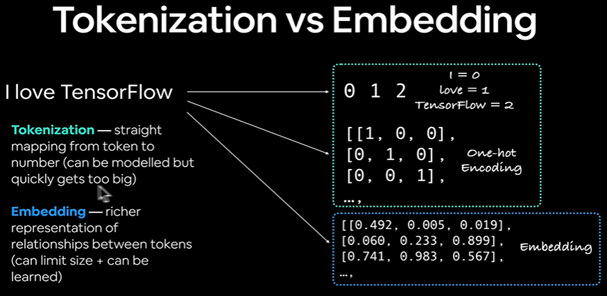

## Converting text into numbers

When dealing with a text problem, one of the first things you'll have to do  before you can build a model is to convert your text to numbers.

There are a few ways to do this, namely :
* Tokenization : direct mapping of token(a token could be a word or character) to number
* Embedding : create a matrix of feature vector for each token(the size of the feature vector can be defined and this embedding can be learned)


### Text vectorization (tokenization)

In [38]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [42]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
# Link to TextVectorization : https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (automatically add <OOV>)
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None, # create group of n-words?
                                    output_mode="int", # how to map tokens to int
                                    output_sequence_length=None, # how long do you want your sequence to be
                                    pad_to_max_tokens = True)


In [45]:
len(train_sentences[0].split())

7

In [48]:
# Find the average number of tokens(words) in the training tweets
round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))

15

In [49]:
# Setup text vectorization variables
max_vocab_length= 10000 # max number of words to have in our vocabulary
max_length = 15 # max length  our sequences will be (e.g. how many words from a Tweet does a model see?)

text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    output_mode ="int",
                                    output_sequence_length=max_length)

In [50]:
# Fit the text vectorizer to training text
text_vectorizer.adapt(train_sentences)

In [51]:
# Create a sample sentence and tokenize it.
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [56]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence} \
        \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
Fire in Pisgah National Forest grows to 375 acres http://t.co/d7zxZ42QW1         

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  42,    4, 3534,  372,  188, 1403,    5, 4178, 1722,    1,    0,
           0,    0,    0,    0]])>

In [58]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in the training data
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most commom words: {top_5_words}" )
print(f"5 least commom words:{bottom_5_words}")

Number of words in vocab: 10000
5 most commom words: ['', '[UNK]', 'the', 'a', 'in']
5 least commom words:['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']
